<h1 align="center"> 
	By Sebastiao Ferreira de Paula Neto
</h1>

<h2 align="center"> 
	Cientista de dados
</h2>

---

<center><img src='https://raw.githubusercontent.com/Tiao553/desafio-dhauz/master/img/churn_classifier.png'></center>

<h1 align="center"> 
	Criando um modelo para prever a evasão
</h1>

É sempre desejavel saber se seu cliente terá tendências a sair do seu serviço com isso conseguindo prever faturamentos e até possíveis problemas que possam vir a acontece. Com o notebook de analise fizemos toda uma apresentação e análise dos dados que estamos utilizando ate extraimos alguns insights a respeitos deles. **Dessa forma, neste notebook colocamos como principal objetivo conseguir criar um modelo que irá conseguir classificar a evasões.**

# objetivos secundários

1. Realizar o tratamento dos dados para execução dos algoritimos.
2. Identificar as features que mais impactam na variável.
3. Rodar o lazypredict para identificar quais algoritimos melhores performam com estes dados.
4. Realizar o hiperparameter tunning.
5. Verificar seus resultados.

---


<h1 align="center"> 
	Processamento dos dados
</h1>

Nesta primeira etapa vamos apenas deixar os dados de forma que os algoritimos aceitem os dados. Para isso temos que ter apenas variaveis numéricas e para transofrmamos as variáveis categoricas em numericas iremos aplicar a tecnica de encolding. Como os dados se apresentam balanceados não iremos precisar balancia-los. Outro ponto a ser realizado é retirar os valores nulos. Portanto, vamos importar os pacotes e vamos a colocar a mão na massa!!!

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler, normalize
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score, roc_curve, confusion_matrix

Com os pacotes importados, agora precisamos importar os dados. Isso pode ser realizado por meio do script abaixo:

In [2]:
#   Importando os dados iniciais
Data = "/home/sebastiao/Desktop/desafio-dhauz/data/churn_challenge_data.csv"
df = pd.read_csv(Data)

Primeira coisa que vamos fazer é tratar os valores nulos. Começando pelos mais faceis vamos pegar aqueles com menos de 2% e vamos eliminar as linhas utilizadas.

In [3]:
aux = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)

for i in (aux[aux.values < 0.02].index):
    df.drop(df[df[i].isnull() == True].index, axis=0, inplace=True)

df.shape

(96534, 99)

Feito isso agora temos que nos preocupar com os casos com grande números de valores faltantes. Muitos desses casos serão bem pontuais, para isso vamos verificar os valores que faltaram a serem tratados primeiramente.

In [4]:
aux = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
aux[aux.values != 0]

numbcars            0.483933
dwllsize            0.372004
HHstatin            0.367746
ownrent             0.324974
dwlltype            0.306825
lor                 0.289307
income              0.240796
adults              0.216266
infobase            0.206694
hnd_webcap          0.102492
prizm_social_one    0.067841
avg6rev             0.027358
avg6qty             0.027358
avg6mou             0.027358
dtype: float64

Para os casos numericos vamos inserir os valores que estão na media, ja os categoricos vamos inserir uma nova categoria de não inserido.

In [5]:
for i in aux[aux.values != 0].index:
    if df[i].dtypes == object:
        imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 'Not_insert')
        imputer = imputer.fit(df[[i]])
        df[[i]] = imputer.transform(df[[i]])
    else:
        imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
        imputer = imputer.fit(df[[i]])
        df[[i]] = imputer.transform(df[[i]])


Agora precisamos gerar o encolder das variaveis categoricas para transforma-las em numericas. Neste primeiro encondelder irei considerar todas as variais como dependentes e transforma-las com o `LabelEncolder`. O script abaixo nos retornar esse resultado.

In [6]:
for i in df[df.columns[df.dtypes == object]]:
    label_encolder = LabelEncoder()
    df[[i]] = label_encolder.fit_transform(df[[i]].values)

Com os dados processados vamos dividir a base em teste e treino para podemos montar o modelo e fazer a sua validação.

In [7]:
previsores = df.drop(columns=['churn','Customer_ID']).copy()
classe = df.churn.copy()

X_train, X_test, y_train, y_test = train_test_split(previsores, classe, test_size = 0.15, random_state = 0)

Outro ponto importantissimo é garantir que os dados estejam em escala semeplhante para que um não tendencie mais que que os outros por falta de escalonamento. Uma das opções para que possamos fazer isso é por meio da padronização dos dados.

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

Desta maneira temos nossos dados ja processados e pronto pára fazermos os teste da importancia das features na classificação da evasão.

---

<h1 align="center"> 
	Feature importance
</h1>

A floresta aleatória consiste em uma série de árvores de decisão. Cada nó das árvores de decisão é uma condição em uma única característica, projetada para dividir o conjunto de dados em dois de modo que valores de resposta similares terminem no mesmo conjunto. A medida baseada na qual a condição (local) ótima é escolhida é chamada de impureza. Ao treinar uma árvore, pode-se calcular o quanto cada característica diminui a impureza ponderada em uma árvore. Para uma floresta, a diminuição da impureza de cada característica pode ser calculada como média e as características são classificadas de acordo com esta medida. Esta é a medida de importância da característica exposta nas implementações da Random Forest no sklearn.

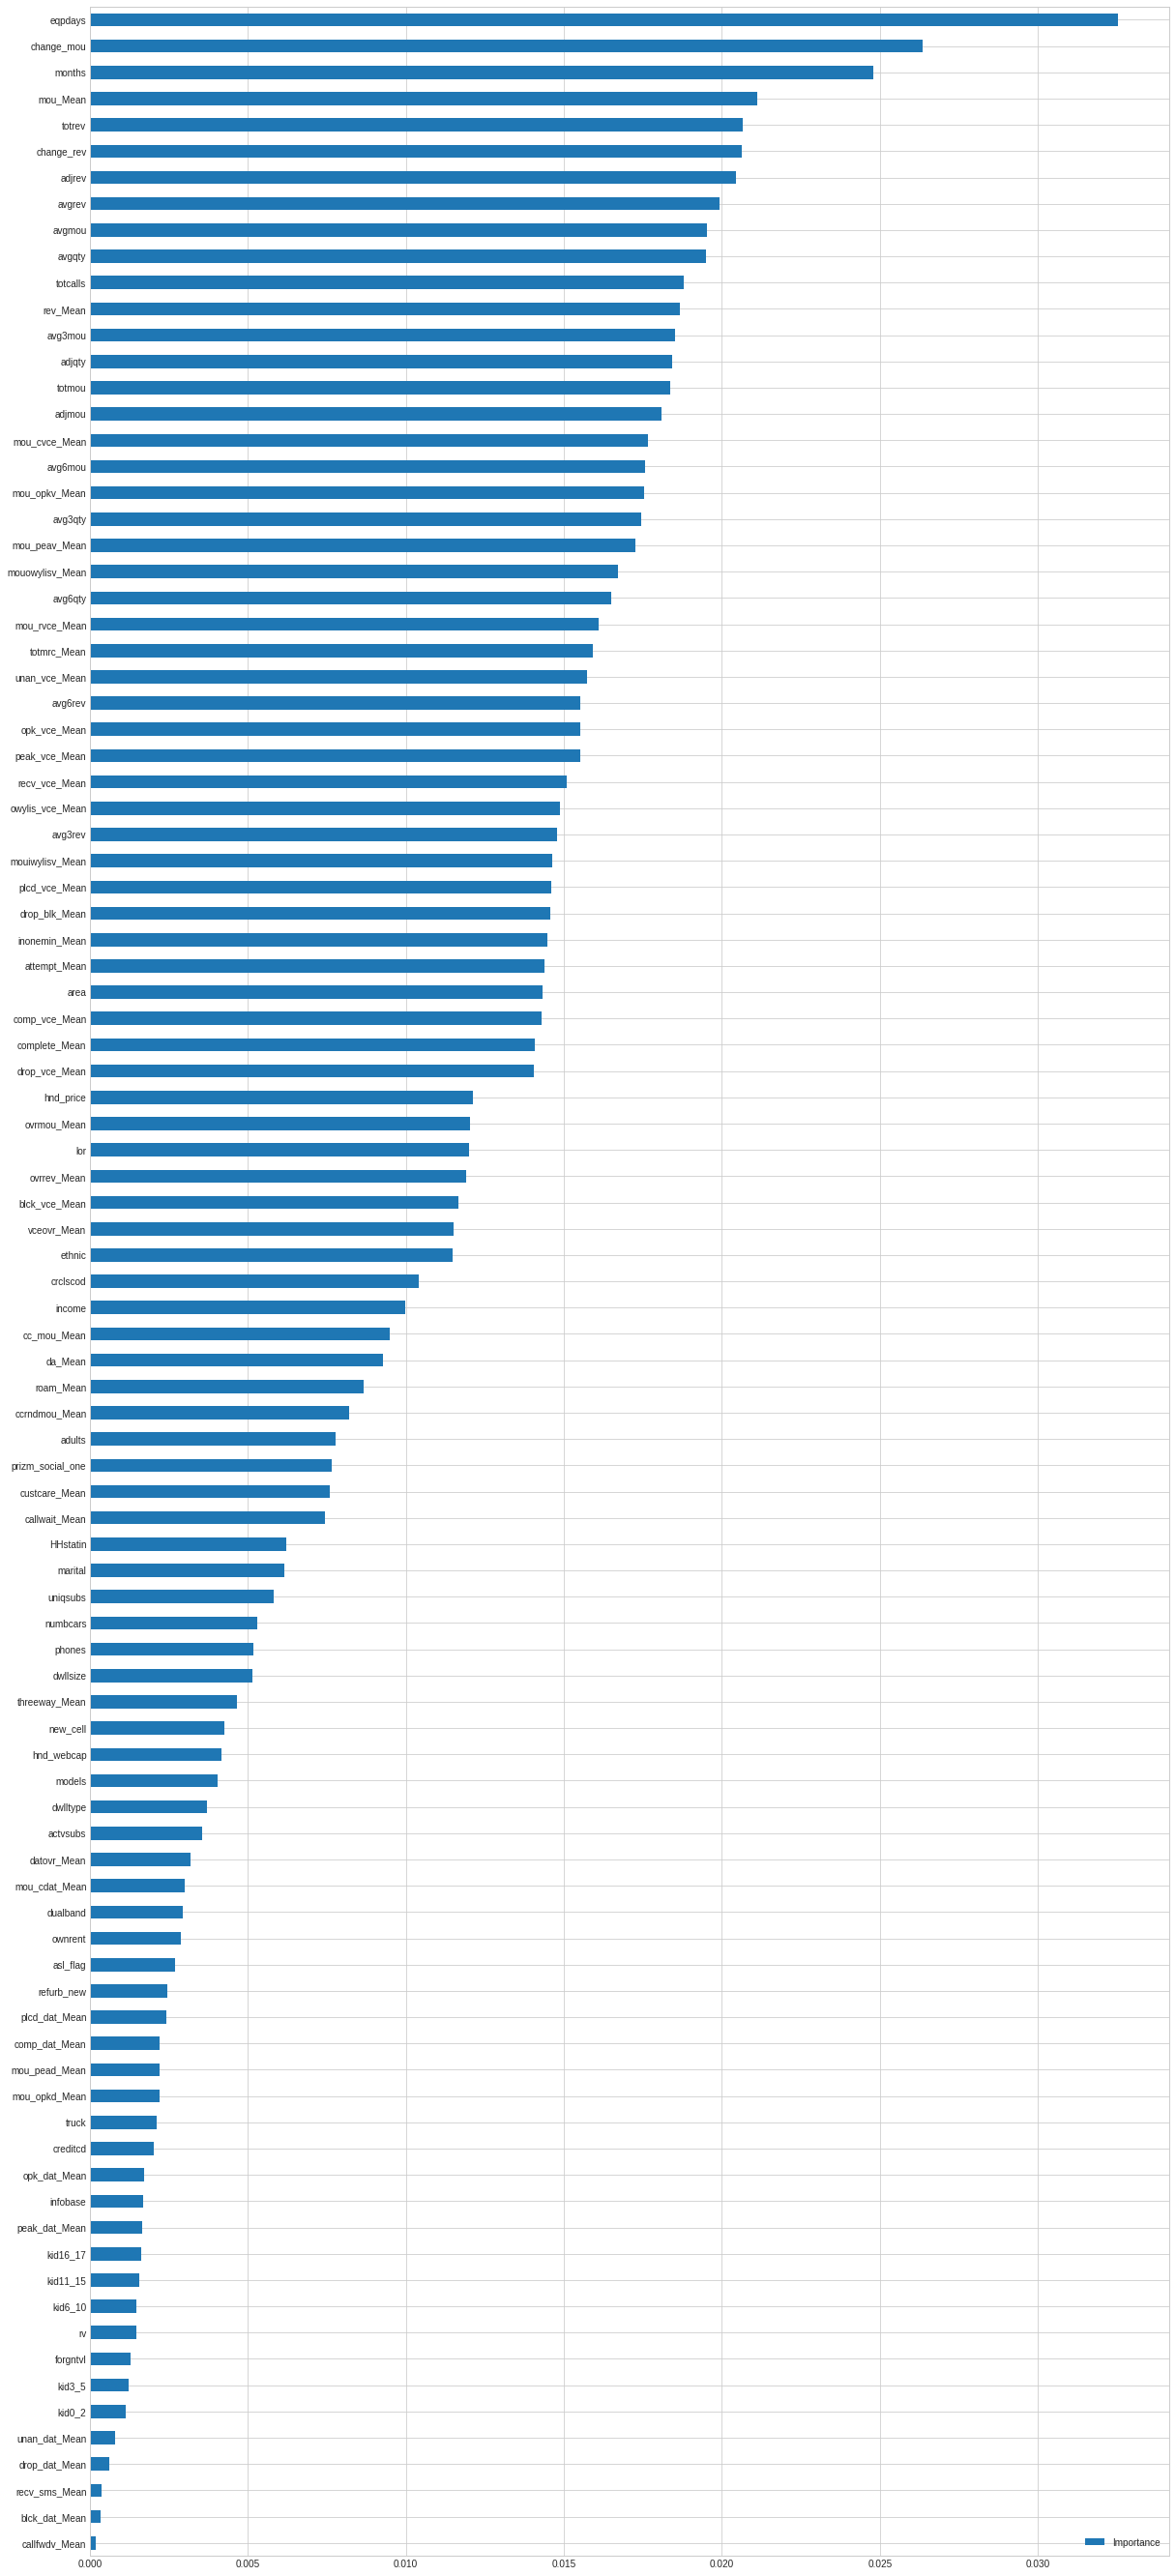

In [9]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=previsores.columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

Avaliadas as importancias das features vamos retirar aquelas que interferem menos de 0.2% no resultado final para obtenção de melhorara a acertividade do algoritimo.

In [10]:
previsores.drop(columns=[*importance[importance.Importance < 0.002].index])
classe = df.churn.copy()

#   Separando em teste e treino
X_train, X_test, y_train, y_test = train_test_split(previsores, classe, test_size = 0.15, random_state = 0)

#   Padronizando os dados
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

---

<h1 align="center"> 
	Model seletion
</h1>

Para seleção de modelos uma boa prática é executar o lazy predict, que como o propio nome diz a predição do preguisoço. Ele ja executa 29 modelos que nos retorna o classification report. Com isso podemos escolher os algoritimos ao qual iremos utilizar. Abaixo temos uma representação de uma aplicação desse package.

In [46]:
## Lazy predict for an initial guide
import lazypredict
from lazypredict.Supervised import LazyClassifier

## As a second step, we run the lazy predict, to a enhanced vision about the best models to fit
clf = LazyClassifier(verbose=0, ignore_warnings=True, predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models.sort_values('Accuracy', ascending=False)

## Now we select the top 4, and run a GridSearch, to tune the hyperparameters
list(models.nlargest(4, columns='Accuracy').reset_index()['Model'])

 59%|█████▊    | 17/29 [10:36<03:54, 19.54s/it]

Infelizmente, depois de quase 1 hora e 10 minuntos o processo se estagnou devido a quantidade de dados e teremos que realizar a construção dos modelos por hipoteses.

O gridsearch é um dos metodos de hiperparameter tunning, mas iremos aplica-lo mais a frente.

---

<h1 align="center"> 
	Model seletion 2.0
</h1>

Para seleção dos modelos vamos tomar como escolha os seguintes algoritimos:

* Regressão logistica
* Ada Boost Classifier
* Ridge classifier

Dessa maniera vamos importar os packages para construção dos modelos:

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [13]:
# Ridgeclassificer
ridge_Persona = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1])
ridge_Persona.fit(X_train, y_train)
previsoes_ridge = ridge_Persona.predict(X_test)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, previsoes_ridge, digits=4))

# Cross-validation
scores = cross_val_score(ridge_Persona, X_train, y_train,  cv=30)
print("Acurácia: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.5970    0.5998    0.5984      7349
           1     0.5857    0.5829    0.5843      7132

    accuracy                         0.5915     14481
   macro avg     0.5914    0.5913    0.5913     14481
weighted avg     0.5914    0.5915    0.5914     14481

Acurácia: 0.59 (+/- 0.02)


In [14]:
# AdaBoosting
Ada_Persona = AdaBoostClassifier(n_estimators=100, random_state=0)
Ada_Persona.fit(X_train, y_train)
previsoes_ada = Ada_Persona.predict(X_test)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, previsoes_ada, digits=4))

# Cross-validation
scores = cross_val_score(Ada_Persona, X_train, y_train,  cv=10)
print("Acurácia: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.6319    0.6066    0.6190      7349
           1     0.6107    0.6359    0.6230      7132

    accuracy                         0.6210     14481
   macro avg     0.6213    0.6212    0.6210     14481
weighted avg     0.6215    0.6210    0.6210     14481

Acurácia: 0.62 (+/- 0.01)


In [15]:
#   Logist Regression
logistic_Persona = LogisticRegression(C=1.5, solver='saga', tol=0.000001, random_state = 1)
logistic_Persona.fit(X_train, y_train)
previsoes_logistic_regression = logistic_Persona.predict(X_test)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, previsoes_logistic_regression, digits=4))

# Cross-validation
scores = cross_val_score(logistic_Persona, X_train, y_train,  cv=10)
print("Acurácia: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.5934    0.5983    0.5958      7349
           1     0.5825    0.5775    0.5800      7132

    accuracy                         0.5881     14481
   macro avg     0.5880    0.5879    0.5879     14481
weighted avg     0.5880    0.5881    0.5880     14481

Acurácia: 0.59 (+/- 0.01)
